In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import anndata as ad
from PIL import Image
from sklearn.cluster import KMeans
import scanpy as sc
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Inputting the AnnData

In [10]:
parent_folder = os.getcwd()
subfolder_name = "adata_baroque_paintings"
file_name = "adata_baroque_paintings_trial6_complementarity.h5ad"

save_path = os.path.join(parent_folder, subfolder_name, file_name)
adata_baroque_paintings_full = sc.read_h5ad(save_path)

In [11]:
adata_baroque_paintings_full

AnnData object with n_obs × n_vars = 286 × 120
    obs: 'Painting_name', 'Width', 'Height', 'Commission_Year', 'Completion_Year', 'Painter', 'sacred', 'Jesuit_Art', 'Baroque_Art', 'Laplacian_Contrast', 'Gradient_Contrast', 'Hybrid_Contrast', 'File Name', 'color_prop_1', 'color_prop_2', 'color_prop_3', 'color_prop_4', 'color_prop_5', 'color_prop_6', 'color_prop_7', 'color_prop_8', 'color_prop_9', 'color_prop_10', 'color_prop_11', 'color_prop_12', 'color_prop_13', 'color_prop_14', 'color_prop_15', 'color_prop_16', 'color_prop_17', 'color_prop_18', 'color_prop_19', 'color_prop_20', 'not_sacred', 'not_Baroque_Art', 'not_Jesuit_Art', 'color_complementarity_score'

In [12]:
adata_baroque_paintings_full.obs

,Painting_name,Width,Height,Commission_Year,Completion_Year,Painter,sacred,Jesuit_Art,Baroque_Art,Laplacian_Contrast,...,color_prop_15,color_prop_16,color_prop_17,color_prop_18,color_prop_19,color_prop_20,not_sacred,not_Baroque_Art,not_Jesuit_Art,color_complementarity_score
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,David with the Head of Goliath,91.3,110.4,1595,1605,Michelangelo Merisi Caravaggio,1,0,1,0.010107,...,0.016200,0.015300,0.014675,0.014350,0.007175,0.006875,0,0,1,0.042089
2,Santa Catalina,128.0,166.0,1598,1599,Michelangelo Merisi Caravaggio,1,0,1,0.007477,...,0.007125,0.007075,0.005350,0.004650,0.003400,0.003400,0,0,1,0.083127
3,Imposición de la casulla a san Ildefonso,55.0,33.0,1600,1600,Peter Paul Rubens,1,0,1,0.015918,...,0.019925,0.019325,0.018600,0.018125,0.011225,0.004700,0,0,1,0.082595
4,La Sagrada Familia,23.0,35.0,1600,1600,Peter Paul Rubens,1,0,1,0.009649,...,0.029500,0.024050,0.013775,0.005925,0.004725,0.004000,0,0,1,0.005416
5,Vulcano y el fuego,126.0,140.0,1600,1600,Peter Paul Rubens,0,0,1,0.012177,...,0.018350,0.016900,0.015575,0.009400,0.007875,0.005100,1,0,1,0.003148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,La Berceuse,0.0,0.0,1888,1888,Vincent van Gogh,0,0,0,0.050316,...,0.028325,0.027550,0.027175,0.026075,0.024800,0.013250,1,1,1,0.119284
283,Self_protrait_VanGogh,0.0,0.0,1889,1889,Vincent van Gogh,0,0,0,0.053616,...,0.023825,0.023425,0.016750,0.015975,0.015425,0.013925,1,1,1,0.372845
284,Selfportrait_with_grey_felt_hat,0.0,0.0,1887,1888,Vincent van Gogh,0,0,0,0.053712,...,0.031175,0.029200,0.028050,0.025850,0.020450,0.009925,1,1,1,0.552021


# Color Proportions

In [13]:
baroque_mask = adata_baroque_paintings_full.obs["Baroque_Art"] == 1
adata_baroque_paintings = adata_baroque_paintings_full[baroque_mask].copy()
adata_baroque_paintings

AnnData object with n_obs × n_vars = 207 × 120
    obs: 'Painting_name', 'Width', 'Height', 'Commission_Year', 'Completion_Year', 'Painter', 'sacred', 'Jesuit_Art', 'Baroque_Art', 'Laplacian_Contrast', 'Gradient_Contrast', 'Hybrid_Contrast', 'File Name', 'color_prop_1', 'color_prop_2', 'color_prop_3', 'color_prop_4', 'color_prop_5', 'color_prop_6', 'color_prop_7', 'color_prop_8', 'color_prop_9', 'color_prop_10', 'color_prop_11', 'color_prop_12', 'color_prop_13', 'color_prop_14', 'color_prop_15', 'color_prop_16', 'color_prop_17', 'color_prop_18', 'color_prop_19', 'color_prop_20', 'not_sacred', 'not_Baroque_Art', 'not_Jesuit_Art', 'color_complementarity_score'

In [14]:
color_proportion_info = [c for c in adata_baroque_paintings.obs.columns if c.startswith("color_prop")]
color_proportion_df = adata_baroque_paintings.obs[color_proportion_info].copy()
color_proportion_df["sum"] = color_proportion_df.sum(axis=1)
color_proportion_df

,color_prop_1,color_prop_2,color_prop_3,color_prop_4,color_prop_5,color_prop_6,color_prop_7,color_prop_8,color_prop_9,color_prop_10,...,color_prop_12,color_prop_13,color_prop_14,color_prop_15,color_prop_16,color_prop_17,color_prop_18,color_prop_19,color_prop_20,sum
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,0.216800,0.169650,0.135850,0.112775,0.073025,0.043750,0.026975,0.025150,0.021925,0.021775,...,0.021075,0.018400,0.016725,0.016200,0.015300,0.014675,0.014350,0.007175,0.006875,1.0
2,0.479325,0.236375,0.064700,0.037850,0.032575,0.021625,0.021125,0.014600,0.012725,0.011300,...,0.009775,0.008925,0.007775,0.007125,0.007075,0.005350,0.004650,0.003400,0.003400,1.0
3,0.114100,0.088600,0.087900,0.082025,0.072925,0.071125,0.068050,0.058825,0.054500,0.052975,...,0.038900,0.034900,0.032725,0.019925,0.019325,0.018600,0.018125,0.011225,0.004700,1.0
4,0.094475,0.085800,0.083950,0.078425,0.075575,0.069225,0.065100,0.065075,0.062425,0.055250,...,0.053475,0.040075,0.035075,0.029500,0.024050,0.013775,0.005925,0.004725,0.004000,1.0
5,0.187600,0.155375,0.132175,0.078050,0.069975,0.060875,0.050075,0.040225,0.033400,0.030675,...,0.021625,0.021150,0.020775,0.018350,0.016900,0.015575,0.009400,0.007875,0.005100,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.250725,0.178750,0.083475,0.065525,0.043500,0.042200,0.033975,0.033375,0.029425,0.026450,...,0.025850,0.025825,0.024225,0.023450,0.023425,0.018975,0.017450,0.017275,0.009800,1.0
204,0.216825,0.127300,0.103850,0.071675,0.061575,0.051150,0.048300,0.045850,0.040400,0.034300,...,0.023800,0.022825,0.022650,0.019550,0.017425,0.017425,0.016075,0.015100,0.011650,1.0
205,0.189100,0.151225,0.123350,0.089125,0.059725,0.043625,0.041050,0.037775,0.035075,0.033300,...,0.028600,0.024425,0.023400,0.018400,0.017625,0.017000,0.016350,0.014175,0.007875,1.0


In [15]:
adata_baroque_paintings.obs.columns

Index(['Painting_name', 'Width', 'Height', 'Commission_Year',
       'Completion_Year', 'Painter', 'sacred', 'Jesuit_Art', 'Baroque_Art',
       'Laplacian_Contrast', 'Gradient_Contrast', 'Hybrid_Contrast',
       'File Name', 'color_prop_1', 'color_prop_2', 'color_prop_3',
       'color_prop_4', 'color_prop_5', 'color_prop_6', 'color_prop_7',
       'color_prop_8', 'color_prop_9', 'color_prop_10', 'color_prop_11',
       'color_prop_12', 'color_prop_13', 'color_prop_14', 'color_prop_15',
       'color_prop_16', 'color_prop_17', 'color_prop_18', 'color_prop_19',
       'color_prop_20', 'not_sacred', 'not_Baroque_Art', 'not_Jesuit_Art',
       'color_complementarity_score'],
      dtype='object')

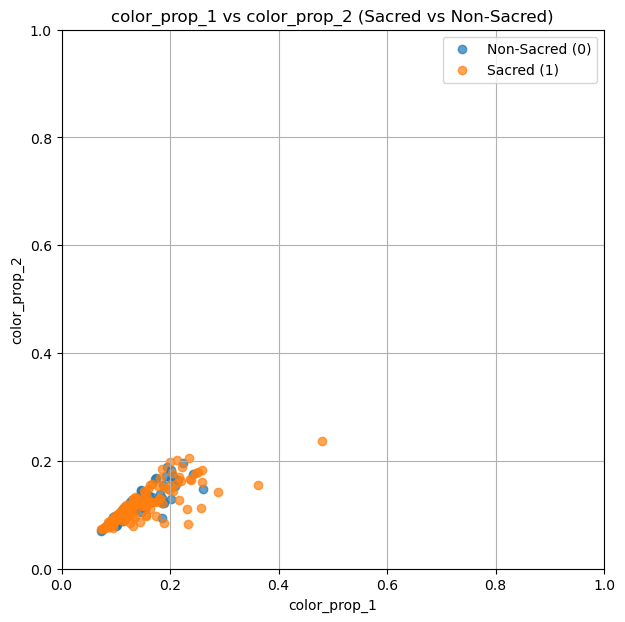

In [16]:
# Obtaining the data from the Adata observations layer
x = adata_baroque_paintings.obs["color_prop_1"]
y = adata_baroque_paintings.obs["color_prop_2"]
sacred = adata_baroque_paintings.obs["sacred"]

# Separating between sacred vs non-sacred
x_sacred = x[sacred == 1]
y_sacred = y[sacred == 1]

x_non = x[sacred == 0]
y_non = y[sacred == 0]

# Plotting 
plt.figure(figsize=(7, 7))

plt.scatter(x_non, y_non, alpha=0.7, label="Non-Sacred (0)")
plt.scatter(x_sacred, y_sacred, alpha=0.7, label="Sacred (1)")

plt.xlabel("color_prop_1")
plt.ylabel("color_prop_2")
plt.title("color_prop_1 vs color_prop_2 (Sacred vs Non-Sacred)")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)

plt.show()